## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import log_loss, f1_score, roc_curve, auc, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from xgboost import XGBRegressor
import lightgbm as lgb
import optuna

## Set file paths for train and predict datasets

In [2]:
train_dataset = "Dataset/Train.csv"
predict_dataset = "Dataset/Test.csv"

## Data Preprocessing

#### Read train and predict datasets

In [3]:
train_df = pd.read_csv(train_dataset)
predict_df = pd.read_csv(predict_dataset)
print("train_df: {}".format(train_df.shape))
print("predict_df: {}".format(predict_df.shape))

train_df: (543, 8)
predict_df: (233, 7)


#### Extract "IsUnderRisk" field from train_df into NumPy array

In [4]:
train_y = np.array([train_df['IsUnderRisk'].values]).T
train_df.drop(['IsUnderRisk'], inplace=True, axis=1)
print("train_y: {}".format(train_y.shape))

train_y: (543, 1)


#### Feature Engineering

In [5]:
# Combine train and predict dataframes
combined_df = train_df.append(predict_df, sort=False, ignore_index=True)
print(combined_df.shape)

(776, 7)


In [6]:
# Calculate different score ratios
combined_df["Fin_Score/(IAS + EAS)"] = combined_df["Fin_Score"] / (combined_df["Internal_Audit_Score"] + combined_df["External_Audit_Score"])
combined_df["Loss_score/(IAS + EAS)"] = combined_df["Loss_score"] / (combined_df["Internal_Audit_Score"] + combined_df["External_Audit_Score"])
combined_df["Loss_score/Fin_Score"] = combined_df["Loss_score"] / combined_df["Fin_Score"]
combined_df["Fin_Score/Location_Score"] = combined_df["Fin_Score"] / combined_df["Location_Score"]
combined_df["Loss_score/Location_Score"] = combined_df["Loss_score"] / combined_df["Location_Score"]
combined_df["(IAS + EAS)/Location_Score"] = (combined_df["Internal_Audit_Score"] + combined_df["External_Audit_Score"]) / combined_df["Location_Score"]
combined_df["Past_Results/Location_Score"] = combined_df["Past_Results"] / combined_df["Location_Score"]

In [7]:
# Convert "Location_Score" to log scale
combined_df['Location_Score_log'] = np.log((1+ combined_df['Location_Score']))

In [8]:
# Binning
combined_df['Past_Results_bin'] = combined_df['Past_Results'].apply(lambda x: "[0-2]" if 0<=x<2 else "[2-4]" if 2<=x<4 else "[4-10]")
combined_df['Loss_Score_bin'] = combined_df['Loss_score'].apply(lambda x: "[0-5]" if 0<=x<5 else "[5-9]" if 5<=x<9 else "[9-15]")

In [9]:
# One-hot encoding
one_hot = pd.get_dummies(combined_df['City'])
combined_df.drop('City', axis = 1, inplace=True)
combined_df = combined_df.join(one_hot)

one_hot = pd.get_dummies(combined_df['Past_Results_bin'])
combined_df.drop('Past_Results_bin', axis = 1, inplace=True)
combined_df = combined_df.join(one_hot)

one_hot = pd.get_dummies(combined_df['Loss_Score_bin'])
combined_df.drop('Loss_Score_bin', axis = 1, inplace=True)
combined_df = combined_df.join(one_hot)

In [10]:
# Box-cox transformation
_, opt_lambda = boxcox(combined_df["Location_Score"])
combined_df['Location_boxcox_lambda_0'] = boxcox((1+combined_df['Location_Score']), lmbda=0)
combined_df['Location_boxcox_lambda_opt'] = boxcox(combined_df['Location_Score'], lmbda=opt_lambda)

_, opt_lambda = boxcox(combined_df["Internal_Audit_Score"])
combined_df['IAS_boxcox_lambda_0'] = boxcox((1+combined_df['Internal_Audit_Score']), lmbda=0)
combined_df['IAS_boxcox_lambda_opt'] = boxcox(combined_df['Internal_Audit_Score'], lmbda=opt_lambda)

_, opt_lambda = boxcox(combined_df["External_Audit_Score"])
combined_df['EAS_boxcox_lambda_0'] = boxcox((1+combined_df['External_Audit_Score']), lmbda=0)
combined_df['EAS_boxcox_lambda_opt'] = boxcox(combined_df['External_Audit_Score'], lmbda=opt_lambda)

_, opt_lambda = boxcox(combined_df["Fin_Score"])
combined_df['Fin_boxcox_lambda_0'] = boxcox((1+combined_df['Fin_Score']), lmbda=0)
combined_df['Fin_boxcox_lambda_opt'] = boxcox(combined_df['Fin_Score'], lmbda=opt_lambda)

#### Create train and predict Numpy arrays and scale them

In [11]:
# Segregate combined_df into train/predict datasets
train_x = combined_df[:543]
predict_x = combined_df[543:]

print("train_x: {}".format(train_x.shape))
print("predict_x: {}".format(predict_x.shape))

train_x: (543, 73)
predict_x: (233, 73)


In [12]:
# Scale the train_x/predict_x arrays
scaler = MinMaxScaler().fit(train_x)
train_x = scaler.transform(train_x)
predict_x = scaler.transform(predict_x)

In [13]:
train_x_full = train_x.copy()
train_y_full = train_y.copy()

#### Split training data into train/test datasets

In [14]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.095, random_state=1)
for train_index, test_index in sss.split(train_x, train_y):
    train_x, test_x = train_x[train_index], train_x[test_index]
    train_y, test_y = train_y[train_index], train_y[test_index]

print("------------------------- Training Dataset -------------------------")
print("train_x shape: {}".format(train_x.shape))
print("train_y shape: {}".format(train_y.shape))

print("\n------------------------- Test Dataset -------------------------")
print("test_x shape: {}".format(test_x.shape))
print("test_y shape: {}".format(test_y.shape))

------------------------- Training Dataset -------------------------
train_x shape: (491, 73)
train_y shape: (491, 1)

------------------------- Test Dataset -------------------------
test_x shape: (52, 73)
test_y shape: (52, 1)


In [15]:
Xtrain_full, Ytrain_full = train_x_full.copy(), train_y_full.copy()
Xtrain, Ytrain = train_x.copy(), train_y.copy()
Xtest, Ytest = test_x.copy(), test_y.copy()
Xpredict = predict_x.copy()

print("------------------------- Training Dataset -------------------------")
print("Xtrain_full shape: {}".format(Xtrain_full.shape))
print("Ytrain_full shape: {}".format(Ytrain_full.shape))
print("Xtrain shape: {}".format(Xtrain.shape))
print("Ytrain shape: {}".format(Ytrain.shape))

print("\n------------------------- Test Dataset -------------------------")
print("Xtest shape: {}".format(Xtest.shape))
print("Ytest shape: {}".format(Ytest.shape))

print("\n------------------------- Prediction Dataset -------------------------")
print("Xpredict shape: {}".format(Xpredict.shape))

------------------------- Training Dataset -------------------------
Xtrain_full shape: (543, 73)
Ytrain_full shape: (543, 1)
Xtrain shape: (491, 73)
Ytrain shape: (491, 1)

------------------------- Test Dataset -------------------------
Xtest shape: (52, 73)
Ytest shape: (52, 1)

------------------------- Prediction Dataset -------------------------
Xpredict shape: (233, 73)


## LightGBM Model

#### Hyperparameters search

In [16]:
# Convert Ytest to one-hot encoding
df = pd.DataFrame(Ytest, columns=["IsUnderRisk"])
test_y = pd.get_dummies(df['IsUnderRisk']).values

In [17]:
# Define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

In [18]:
def objective(trial):
    
    params = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "num_class": 2,
        "verbosity": -1,
        "boosting_type": "gbdt",
        "is_unbalance": True,
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-2, 1e-1),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-4, 1.0),
        "num_leaves": trial.suggest_int("num_leaves", 31, 150),
        "max_depth": trial.suggest_int("max_depth", 7, 20),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.5, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.5, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 5, 20),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 20),
    }
    
    y_pred = 0
    counter = 0
    for train, val in kfold.split(Xtrain, Ytrain):
        counter += 1
    
        train_x, train_y = Xtrain[train], Ytrain[train]
        val_x, val_y = Xtrain[val], Ytrain[val]

        lgtrain = lgb.Dataset(train_x, label=train_y.ravel())
        lgvalidation = lgb.Dataset(val_x, label=val_y.ravel())

        model = lgb.train(params, lgtrain, valid_sets=[lgvalidation], 
                          num_boost_round=5000, early_stopping_rounds=200, verbose_eval=False)
        pred = model.predict(Xtest, num_iteration=model.best_iteration)

        y_pred += pred

    y_pred /= float(counter)
    loss = log_loss(test_y, y_pred)
    return loss

In [19]:
study = optuna.create_study()
study.optimize(objective, n_trials=100)

[I 2020-05-17 03:42:59,044] Finished trial#0 with value: 0.29788070138178957 with parameters: {'learning_rate': 0.012861639373024798, 'lambda_l2': 0.04163724719386599, 'num_leaves': 83, 'max_depth': 15, 'feature_fraction': 0.5323909251210064, 'bagging_fraction': 0.5341745344764312, 'bagging_freq': 10, 'min_child_samples': 20}. Best is trial#0 with value: 0.29788070138178957.
[I 2020-05-17 03:43:05,181] Finished trial#1 with value: 0.20312529157299744 with parameters: {'learning_rate': 0.08695848060171779, 'lambda_l2': 0.0001390706666589693, 'num_leaves': 130, 'max_depth': 12, 'feature_fraction': 0.724756136864998, 'bagging_fraction': 0.8586918576584837, 'bagging_freq': 13, 'min_child_samples': 1}. Best is trial#1 with value: 0.20312529157299744.
[I 2020-05-17 03:43:11,781] Finished trial#2 with value: 0.2536199464449015 with parameters: {'learning_rate': 0.0629504412933561, 'lambda_l2': 0.003262450509826992, 'num_leaves': 95, 'max_depth': 9, 'feature_fraction': 0.5740899991226749, 'bag

[I 2020-05-17 03:45:00,257] Finished trial#21 with value: 0.2129073334072194 with parameters: {'learning_rate': 0.0979880965570098, 'lambda_l2': 0.00010147742010778163, 'num_leaves': 150, 'max_depth': 19, 'feature_fraction': 0.8806773733855006, 'bagging_fraction': 0.8451235694832799, 'bagging_freq': 19, 'min_child_samples': 1}. Best is trial#15 with value: 0.17789931449541957.
[I 2020-05-17 03:45:07,135] Finished trial#22 with value: 0.19466711417600163 with parameters: {'learning_rate': 0.08121538521941772, 'lambda_l2': 0.00010274933387469253, 'num_leaves': 149, 'max_depth': 19, 'feature_fraction': 0.8292810458013917, 'bagging_fraction': 0.8193262003904099, 'bagging_freq': 18, 'min_child_samples': 1}. Best is trial#15 with value: 0.17789931449541957.
[I 2020-05-17 03:45:10,905] Finished trial#23 with value: 0.2215473479350557 with parameters: {'learning_rate': 0.09520431538100567, 'lambda_l2': 0.00043751806681139926, 'num_leaves': 120, 'max_depth': 17, 'feature_fraction': 0.7787513080

[I 2020-05-17 03:47:13,924] Finished trial#42 with value: 0.22245043018412064 with parameters: {'learning_rate': 0.06794454598957196, 'lambda_l2': 0.05440482441067249, 'num_leaves': 145, 'max_depth': 15, 'feature_fraction': 0.5724767227579888, 'bagging_fraction': 0.8708824084427341, 'bagging_freq': 14, 'min_child_samples': 1}. Best is trial#15 with value: 0.17789931449541957.
[I 2020-05-17 03:47:19,855] Finished trial#43 with value: 0.22979842022473648 with parameters: {'learning_rate': 0.05533041347069292, 'lambda_l2': 0.041177370290879534, 'num_leaves': 133, 'max_depth': 14, 'feature_fraction': 0.8427164596873711, 'bagging_fraction': 0.8488884512386221, 'bagging_freq': 12, 'min_child_samples': 3}. Best is trial#15 with value: 0.17789931449541957.
[I 2020-05-17 03:47:24,948] Finished trial#44 with value: 0.2412107727169966 with parameters: {'learning_rate': 0.07818465896250303, 'lambda_l2': 0.08733723136513291, 'num_leaves': 146, 'max_depth': 18, 'feature_fraction': 0.8012067980596009

[I 2020-05-17 03:49:17,239] Finished trial#63 with value: 0.2395193591266677 with parameters: {'learning_rate': 0.0749884498423293, 'lambda_l2': 0.0004286326839275613, 'num_leaves': 117, 'max_depth': 8, 'feature_fraction': 0.7276514379691508, 'bagging_fraction': 0.7888862340418186, 'bagging_freq': 10, 'min_child_samples': 3}. Best is trial#15 with value: 0.17789931449541957.
[I 2020-05-17 03:49:22,882] Finished trial#64 with value: 0.2189461496516571 with parameters: {'learning_rate': 0.08491940168567697, 'lambda_l2': 0.00024117163139375392, 'num_leaves': 147, 'max_depth': 8, 'feature_fraction': 0.8908425793554269, 'bagging_fraction': 0.8162115585825498, 'bagging_freq': 12, 'min_child_samples': 2}. Best is trial#15 with value: 0.17789931449541957.
[I 2020-05-17 03:49:27,815] Finished trial#65 with value: 0.23747520410821898 with parameters: {'learning_rate': 0.08461327239453327, 'lambda_l2': 0.0011471627985233516, 'num_leaves': 142, 'max_depth': 7, 'feature_fraction': 0.776276446117564

[I 2020-05-17 03:51:27,720] Finished trial#84 with value: 0.2111912057613966 with parameters: {'learning_rate': 0.07528888502036096, 'lambda_l2': 0.0003844137038042234, 'num_leaves': 144, 'max_depth': 13, 'feature_fraction': 0.703638353304917, 'bagging_fraction': 0.7854047912183757, 'bagging_freq': 18, 'min_child_samples': 1}. Best is trial#15 with value: 0.17789931449541957.
[I 2020-05-17 03:51:34,749] Finished trial#85 with value: 0.2052887563183141 with parameters: {'learning_rate': 0.06626644498850742, 'lambda_l2': 0.0005432532995991656, 'num_leaves': 148, 'max_depth': 10, 'feature_fraction': 0.7238737590251572, 'bagging_fraction': 0.807801807093513, 'bagging_freq': 18, 'min_child_samples': 1}. Best is trial#15 with value: 0.17789931449541957.
[I 2020-05-17 03:51:41,094] Finished trial#86 with value: 0.22731164226926712 with parameters: {'learning_rate': 0.07099778653499787, 'lambda_l2': 0.000295550718390724, 'num_leaves': 136, 'max_depth': 12, 'feature_fraction': 0.820105032572670

In [20]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("Value: {}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
Value: 0.17789931449541957
Params: 
 learning_rate: 0.065055700257719
 lambda_l2: 0.00011595363540523085
 num_leaves: 143
 max_depth: 18
 feature_fraction: 0.9715793035857434
 bagging_fraction: 0.8487004906510373
 bagging_freq: 15
 min_child_samples: 1


#### Building the model

In [21]:
# Define model hyperparameters
params = {}
params["objective"] = 'multiclass'
params["metric"] = 'multi_logloss'
params["num_class"] = 2
params["is_unbalance"] = True
params["boosting"] = 'gbdt'
params["max_depth"] = 18
params["num_leaves"] = 143
params["learning_rate"] = 0.065
params["bagging_fraction"] = 0.85
params["feature_fraction"] = 0.97
params["bagging_freq"] = 15
params["bagging_seed"] = 10
params["lambda_l2"] = 0.0001
params["min_data_in_leaf"] = 1
params["verbosity"] = -1
num_rounds = 5000

In [22]:
# Define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
y_pred_lgb = 0

In [23]:
# Train the model using K-fold
counter = 0

for train, val in kfold.split(Xtrain, Ytrain):
    counter += 1

    train_x, train_y = Xtrain[train], Ytrain[train]
    val_x, val_y = Xtrain[val], Ytrain[val]

    lgtrain = lgb.Dataset(train_x, label=train_y.ravel())
    lgvalidation = lgb.Dataset(val_x, label=val_y.ravel())

    model = lgb.train(params, lgtrain, num_rounds, valid_sets=[lgvalidation], early_stopping_rounds=200, verbose_eval=1000)
    pred = model.predict(Xtest, num_iteration=model.best_iteration)

    y_pred_lgb += pred

y_pred_lgb /= float(counter)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.344238
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 0.400917
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 0.415268
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[55]	valid_0's multi_logloss: 0.296596
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 0.382385


#### Validating the model

In [25]:
#Print log_loss
loss = log_loss(test_y, y_pred_lgb)
print('Overall log_loss:', loss)

#Print accuracy
y_pred_binary = np.array([np.argmax(y_pred_lgb, axis=1)]).T
acc_score = accuracy_score(Ytest, y_pred_binary)
f1 = f1_score(Ytest, y_pred_binary)
print('Overall accuracy:', acc_score)
print('Overall F1-Score:', f1)

Overall log_loss: 0.23151800765869648
Overall accuracy: 0.9615384615384616
Overall F1-Score: 0.9696969696969697


## XGBoost Model

#### Hyperparameters Search

In [26]:
# Convert Ytest to one-hot encoding
df = pd.DataFrame(Ytest, columns=["IsUnderRisk"])
test_y = pd.get_dummies(df['IsUnderRisk']).values

In [27]:
# Define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

In [28]:
def objective(trial):
       
    y_pred = 0
    counter = 0
    
    for train, val in kfold.split(Xtrain, Ytrain):
        counter += 1
    
        train_x, train_y = Xtrain[train], Ytrain[train]
        val_x, val_y = Xtrain[val], Ytrain[val]
        df = pd.DataFrame(train_y, columns=['IsUnderRisk'])
        neg, pos = np.bincount(df['IsUnderRisk'])
        
        model = XGBRegressor(
            objective='multi:softprob',
            eval_metric='mlogloss',
            booster='gbtree',
            sample_type='uniform',
            tree_method='hist',
            scale_pos_weight=neg/pos,
            grow_policy='lossguide',
            num_round=5000,
            num_class=2,
            rate_drop=trial.suggest_uniform("rate_drop", 0.1, 1.0),
            learning_rate=trial.suggest_loguniform("learning_rate", 1e-2, 1e-1),
            min_split_loss=trial.suggest_uniform("min_split_loss", 0.1, 1.0),
            max_depth=trial.suggest_int("max_depth", 6, 20),
            min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
            subsample=trial.suggest_uniform("subsample", 0.5, 1.0),
            colsample_bytree=trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
            reg_lambda=trial.suggest_loguniform("reg_lambda", 1e-4, 1.0),
            max_leaves=trial.suggest_int("max_leaves", 31, 150)
        )


        model.fit(train_x, train_y, eval_set=[(val_x, val_y)], early_stopping_rounds=200, verbose=False)
        pred = model.predict(Xtest, ntree_limit=model.best_ntree_limit)
        y_pred += pred

    y_pred /= float(counter)
    loss = log_loss(test_y, y_pred)
    return loss

In [29]:
study = optuna.create_study()
study.optimize(objective, n_trials=100)

[I 2020-05-17 03:55:38,871] Finished trial#0 with value: 0.26245428750721306 with parameters: {'rate_drop': 0.9905031255556502, 'learning_rate': 0.020270035128954752, 'min_split_loss': 0.8385572820979624, 'max_depth': 18, 'min_child_weight': 1, 'subsample': 0.7458417412934213, 'colsample_bytree': 0.9501800504375748, 'reg_lambda': 0.011657154972020543, 'max_leaves': 65}. Best is trial#0 with value: 0.26245428750721306.
[I 2020-05-17 03:55:41,248] Finished trial#1 with value: 0.2969573214291953 with parameters: {'rate_drop': 0.13912805090138006, 'learning_rate': 0.03338718939352985, 'min_split_loss': 0.4732110310299066, 'max_depth': 13, 'min_child_weight': 6, 'subsample': 0.8574231818125855, 'colsample_bytree': 0.6989966752436598, 'reg_lambda': 0.0014208389259836433, 'max_leaves': 149}. Best is trial#0 with value: 0.26245428750721306.
[I 2020-05-17 03:55:43,978] Finished trial#2 with value: 0.31164011287574583 with parameters: {'rate_drop': 0.6168546601896492, 'learning_rate': 0.03288683

[I 2020-05-17 03:56:40,686] Finished trial#19 with value: 0.25119113424219763 with parameters: {'rate_drop': 0.3061275351579463, 'learning_rate': 0.09950752034629472, 'min_split_loss': 0.6706699003886116, 'max_depth': 11, 'min_child_weight': 2, 'subsample': 0.6598062237419653, 'colsample_bytree': 0.8003039104158249, 'reg_lambda': 0.18064851083929173, 'max_leaves': 47}. Best is trial#16 with value: 0.23350405293660095.
[I 2020-05-17 03:56:43,025] Finished trial#20 with value: 0.2976320755417244 with parameters: {'rate_drop': 0.14508990977279343, 'learning_rate': 0.051872217759437476, 'min_split_loss': 0.9281781759717495, 'max_depth': 14, 'min_child_weight': 4, 'subsample': 0.5132226675316061, 'colsample_bytree': 0.5262481919314042, 'reg_lambda': 0.04849179083557265, 'max_leaves': 59}. Best is trial#16 with value: 0.23350405293660095.
[I 2020-05-17 03:56:46,428] Finished trial#21 with value: 0.2543855407633461 with parameters: {'rate_drop': 0.29670958504933853, 'learning_rate': 0.0993447

[I 2020-05-17 03:57:45,529] Finished trial#38 with value: 0.2713002726758042 with parameters: {'rate_drop': 0.5692208731971806, 'learning_rate': 0.061751329563886605, 'min_split_loss': 0.7982100974687265, 'max_depth': 13, 'min_child_weight': 2, 'subsample': 0.502626550112207, 'colsample_bytree': 0.9080870110110367, 'reg_lambda': 0.0008367457833281718, 'max_leaves': 77}. Best is trial#16 with value: 0.23350405293660095.
[I 2020-05-17 03:57:48,019] Finished trial#39 with value: 0.3025057463763425 with parameters: {'rate_drop': 0.5192408938654622, 'learning_rate': 0.030925402867480797, 'min_split_loss': 0.9018413062556854, 'max_depth': 15, 'min_child_weight': 6, 'subsample': 0.699388322666695, 'colsample_bytree': 0.9704707724197711, 'reg_lambda': 0.00033152885778997386, 'max_leaves': 89}. Best is trial#16 with value: 0.23350405293660095.
[I 2020-05-17 03:57:53,421] Finished trial#40 with value: 0.24963127721387607 with parameters: {'rate_drop': 0.39354608155256865, 'learning_rate': 0.0372

[I 2020-05-17 03:58:56,855] Finished trial#57 with value: 0.2599505823678695 with parameters: {'rate_drop': 0.739297940250474, 'learning_rate': 0.08302337436528782, 'min_split_loss': 0.5924431667407155, 'max_depth': 14, 'min_child_weight': 3, 'subsample': 0.7288169706445354, 'colsample_bytree': 0.9013994073216195, 'reg_lambda': 0.0003062719301821823, 'max_leaves': 130}. Best is trial#50 with value: 0.2252303705049249.
[I 2020-05-17 03:59:00,225] Finished trial#58 with value: 0.25398820771190983 with parameters: {'rate_drop': 0.6020516446678182, 'learning_rate': 0.06644463203861019, 'min_split_loss': 0.23391314519726342, 'max_depth': 16, 'min_child_weight': 2, 'subsample': 0.6801072709237003, 'colsample_bytree': 0.9346239560413945, 'reg_lambda': 0.00010843898789962302, 'max_leaves': 111}. Best is trial#50 with value: 0.2252303705049249.
[I 2020-05-17 03:59:04,227] Finished trial#59 with value: 0.23426796915009618 with parameters: {'rate_drop': 0.5125094548781328, 'learning_rate': 0.0963

[I 2020-05-17 04:00:13,239] Finished trial#76 with value: 0.23067572035898382 with parameters: {'rate_drop': 0.702498392053422, 'learning_rate': 0.08010386924311004, 'min_split_loss': 0.6208411770242499, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.7237886650078514, 'colsample_bytree': 0.9247133259068495, 'reg_lambda': 0.0001990456986920183, 'max_leaves': 134}. Best is trial#65 with value: 0.22179049923299596.
[I 2020-05-17 04:00:17,406] Finished trial#77 with value: 0.21993077066368782 with parameters: {'rate_drop': 0.5998830073028594, 'learning_rate': 0.0811996296321885, 'min_split_loss': 0.6233174862472998, 'max_depth': 11, 'min_child_weight': 1, 'subsample': 0.8287817830720072, 'colsample_bytree': 0.9888421559960239, 'reg_lambda': 0.0004603238994686878, 'max_leaves': 133}. Best is trial#77 with value: 0.21993077066368782.
[I 2020-05-17 04:00:20,798] Finished trial#78 with value: 0.24780243907410365 with parameters: {'rate_drop': 0.5895028411818274, 'learning_rate': 0.0918

[I 2020-05-17 04:01:27,972] Finished trial#95 with value: 0.22164032253651664 with parameters: {'rate_drop': 0.5987837766398006, 'learning_rate': 0.08325717197681957, 'min_split_loss': 0.6513658981367919, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.8880573684164744, 'colsample_bytree': 0.9588733973723959, 'reg_lambda': 0.0009553455084961139, 'max_leaves': 140}. Best is trial#84 with value: 0.2155609935737.
[I 2020-05-17 04:01:32,359] Finished trial#96 with value: 0.22089034175643554 with parameters: {'rate_drop': 0.6052432449630522, 'learning_rate': 0.09439087562358525, 'min_split_loss': 0.6275665631113513, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.8879001059171142, 'colsample_bytree': 0.960507128447917, 'reg_lambda': 0.0009452039612672788, 'max_leaves': 141}. Best is trial#84 with value: 0.2155609935737.
[I 2020-05-17 04:01:35,302] Finished trial#97 with value: 0.282596019992175 with parameters: {'rate_drop': 0.5590984457544024, 'learning_rate': 0.0934101510135

In [30]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("Value: {}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
Value: 0.2155609935737
Params: 
 rate_drop: 0.4801332751620107
 learning_rate: 0.08531195984139665
 min_split_loss: 0.6926294843492041
 max_depth: 9
 min_child_weight: 1
 subsample: 0.8976413681648234
 colsample_bytree: 0.9589671956244543
 reg_lambda: 0.0007390830528564916
 max_leaves: 141


#### Building the model

In [31]:
# Define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
y_pred_xgb = 0

In [32]:
# Train the model using K-fold
counter = 0

for train, val in kfold.split(Xtrain, Ytrain):
    counter += 1

    train_x, train_y = Xtrain[train], Ytrain[train]
    val_x, val_y = Xtrain[val], Ytrain[val]
    df = pd.DataFrame(train_y, columns=['IsUnderRisk'])
    neg, pos = np.bincount(df['IsUnderRisk'])
    
    model = XGBRegressor(
        objective='multi:softprob',
        eval_metric='mlogloss',
        booster='gbtree',
        sample_type='uniform',
        tree_method='hist',
        scale_pos_weight=neg/pos,
        grow_policy='lossguide',
        num_round=5000,
        num_class=2,
        rate_drop=0.48,
        learning_rate=0.085,
        min_split_loss=0.69,
        max_depth=9,
        min_child_weight=1,
        subsample=0.898,
        colsample_bytree=0.96,
        reg_lambda=0.0007,
        max_leaves=141
    )

    model.fit(train_x, train_y, eval_set=[(val_x, val_y)], early_stopping_rounds=200, verbose=True)
    pred = model.predict(Xtest, ntree_limit=model.best_ntree_limit)

    y_pred_xgb += pred

y_pred_xgb /= float(counter)

[0]	validation_0-mlogloss:0.64495
Will train until validation_0-mlogloss hasn't improved in 200 rounds.
[1]	validation_0-mlogloss:0.60392
[2]	validation_0-mlogloss:0.57138
[3]	validation_0-mlogloss:0.53841
[4]	validation_0-mlogloss:0.51451
[5]	validation_0-mlogloss:0.49772
[6]	validation_0-mlogloss:0.48086
[7]	validation_0-mlogloss:0.46596
[8]	validation_0-mlogloss:0.45203
[9]	validation_0-mlogloss:0.44091
[10]	validation_0-mlogloss:0.43186
[11]	validation_0-mlogloss:0.42248
[12]	validation_0-mlogloss:0.41012
[13]	validation_0-mlogloss:0.40385
[14]	validation_0-mlogloss:0.39458
[15]	validation_0-mlogloss:0.38934
[16]	validation_0-mlogloss:0.38606
[17]	validation_0-mlogloss:0.38160
[18]	validation_0-mlogloss:0.37974
[19]	validation_0-mlogloss:0.37581
[20]	validation_0-mlogloss:0.37329
[21]	validation_0-mlogloss:0.37119
[22]	validation_0-mlogloss:0.36706
[23]	validation_0-mlogloss:0.36773
[24]	validation_0-mlogloss:0.36781
[25]	validation_0-mlogloss:0.36544
[26]	validation_0-mlogloss:0.3

[29]	validation_0-mlogloss:0.31443
[30]	validation_0-mlogloss:0.31310
[31]	validation_0-mlogloss:0.30847
[32]	validation_0-mlogloss:0.30507
[33]	validation_0-mlogloss:0.30389
[34]	validation_0-mlogloss:0.30302
[35]	validation_0-mlogloss:0.30217
[36]	validation_0-mlogloss:0.30014
[37]	validation_0-mlogloss:0.30015
[38]	validation_0-mlogloss:0.30047
[39]	validation_0-mlogloss:0.29991
[40]	validation_0-mlogloss:0.29932
[41]	validation_0-mlogloss:0.30007
[42]	validation_0-mlogloss:0.29917
[43]	validation_0-mlogloss:0.29830
[44]	validation_0-mlogloss:0.29675
[45]	validation_0-mlogloss:0.29667
[46]	validation_0-mlogloss:0.29711
[47]	validation_0-mlogloss:0.29720
[48]	validation_0-mlogloss:0.29737
[49]	validation_0-mlogloss:0.29561
[50]	validation_0-mlogloss:0.29586
[51]	validation_0-mlogloss:0.29549
[52]	validation_0-mlogloss:0.29677
[53]	validation_0-mlogloss:0.29817
[54]	validation_0-mlogloss:0.29840
[55]	validation_0-mlogloss:0.29844
[56]	validation_0-mlogloss:0.29847
[57]	validation_0-ml

[60]	validation_0-mlogloss:0.29359
[61]	validation_0-mlogloss:0.29419
[62]	validation_0-mlogloss:0.29417
[63]	validation_0-mlogloss:0.29413
[64]	validation_0-mlogloss:0.29456
[65]	validation_0-mlogloss:0.29406
[66]	validation_0-mlogloss:0.29464
[67]	validation_0-mlogloss:0.29464
[68]	validation_0-mlogloss:0.29398
[69]	validation_0-mlogloss:0.29396
[70]	validation_0-mlogloss:0.29398
[71]	validation_0-mlogloss:0.29452
[72]	validation_0-mlogloss:0.29451
[73]	validation_0-mlogloss:0.29448
[74]	validation_0-mlogloss:0.29446
[75]	validation_0-mlogloss:0.29555
[76]	validation_0-mlogloss:0.29554
[77]	validation_0-mlogloss:0.29680
[78]	validation_0-mlogloss:0.29672
[79]	validation_0-mlogloss:0.29743
[80]	validation_0-mlogloss:0.29831
[81]	validation_0-mlogloss:0.29830
[82]	validation_0-mlogloss:0.29785
[83]	validation_0-mlogloss:0.29784
[84]	validation_0-mlogloss:0.29784
[85]	validation_0-mlogloss:0.29862
[86]	validation_0-mlogloss:0.30032
[87]	validation_0-mlogloss:0.30142
[88]	validation_0-ml

#### Validating the model

In [33]:
#Print log_loss
loss = log_loss(test_y, y_pred_xgb)
print('Overall log_loss of model:', loss)

#Print accuracy
y_pred_binary = np.array([np.argmax(y_pred_xgb, axis=1)]).T
acc_score = accuracy_score(Ytest, y_pred_binary)
f1 = f1_score(Ytest, y_pred_binary)
print('Overall accuracy:', acc_score)
print('Overall F1-Score:', f1)

Overall log_loss of model: 0.21929424030419725
Overall accuracy: 0.9038461538461539
Overall F1-Score: 0.923076923076923


## Validating the stacked model

In [34]:
y_pred = (y_pred_lgb + y_pred_xgb)/2

In [35]:
#Print log_loss
loss = log_loss(test_y, y_pred)
print('Overall log_loss of model:', loss)

#Print accuracy
y_pred_binary = np.array([np.argmax(y_pred, axis=1)]).T
acc_score = accuracy_score(Ytest, y_pred_binary)
f1 = f1_score(Ytest, y_pred_binary)
print('Overall accuracy:', acc_score)
print('Overall F1-Score:', f1)

Overall log_loss of model: 0.21721484412817885
Overall accuracy: 0.9423076923076923
Overall F1-Score: 0.9538461538461539


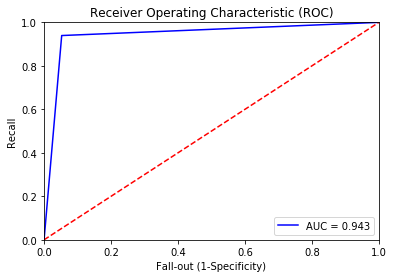

AUC score: 0.9433811802232857


In [36]:
#Print Area Under Curve
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(Ytest, y_pred_binary)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc)

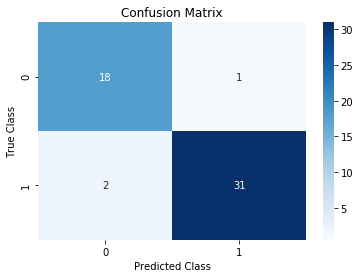

In [37]:
#Print Confusion Matrix
cm = confusion_matrix(Ytest, y_pred_binary)
labels = ['0', '1']
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.5);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

## Training both models on entire data

#### LightGBM Model

In [38]:
# Define model hyperparameters
params = {}
params["objective"] = 'multiclass'
params["metric"] = 'multi_logloss'
params["num_class"] = 2
params["is_unbalance"] = True
params["boosting"] = 'gbdt'
params["max_depth"] = 18
params["num_leaves"] = 143
params["learning_rate"] = 0.065
params["bagging_fraction"] = 0.85
params["feature_fraction"] = 0.97
params["bagging_freq"] = 15
params["bagging_seed"] = 10
params["lambda_l2"] = 0.0001
params["min_data_in_leaf"] = 1
params["verbosity"] = -1
num_rounds = 5000

In [39]:
# Define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
y_pred_lgb = 0

In [40]:
# Train the model using K-fold
counter = 0

for train, val in kfold.split(Xtrain_full, Ytrain_full):
    counter += 1

    train_x, train_y = Xtrain_full[train], Ytrain_full[train]
    val_x, val_y = Xtrain_full[val], Ytrain_full[val]

    lgtrain = lgb.Dataset(train_x, label=train_y.ravel())
    lgvalidation = lgb.Dataset(val_x, label=val_y.ravel())

    model = lgb.train(params, lgtrain, num_rounds, valid_sets=[lgvalidation], early_stopping_rounds=200, verbose_eval=1000)
    pred = model.predict(Xpredict, num_iteration=model.best_iteration)

    y_pred_lgb += pred

y_pred_lgb /= float(counter)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	valid_0's multi_logloss: 0.344398
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[34]	valid_0's multi_logloss: 0.387493
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 0.41068
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[79]	valid_0's multi_logloss: 0.31425
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[39]	valid_0's multi_logloss: 0.371788


#### XGBoost Model

In [41]:
# Define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
y_pred_xgb = 0

In [42]:
# Train the model using K-fold
counter = 0

for train, val in kfold.split(Xtrain_full, Ytrain_full):
    counter += 1

    train_x, train_y = Xtrain_full[train], Ytrain_full[train]
    val_x, val_y = Xtrain_full[val], Ytrain_full[val]
    df = pd.DataFrame(train_y, columns=['IsUnderRisk'])
    neg, pos = np.bincount(df['IsUnderRisk'])
    
    model = XGBRegressor(
        objective='multi:softprob',
        eval_metric='mlogloss',
        booster='gbtree',
        sample_type='uniform',
        tree_method='hist',
        scale_pos_weight=neg/pos,
        grow_policy='lossguide',
        num_round=5000,
        num_class=2,
        rate_drop=0.48,
        learning_rate=0.085,
        min_split_loss=0.69,
        max_depth=9,
        min_child_weight=1,
        subsample=0.898,
        colsample_bytree=0.96,
        reg_lambda=0.0007,
        max_leaves=141
    )

    model.fit(train_x, train_y, eval_set=[(val_x, val_y)], early_stopping_rounds=200, verbose=True)
    pred = model.predict(Xpredict, ntree_limit=model.best_ntree_limit)

    y_pred_xgb += pred

y_pred_xgb /= float(counter)

[0]	validation_0-mlogloss:0.64233
Will train until validation_0-mlogloss hasn't improved in 200 rounds.
[1]	validation_0-mlogloss:0.59964
[2]	validation_0-mlogloss:0.56358
[3]	validation_0-mlogloss:0.53224
[4]	validation_0-mlogloss:0.50574
[5]	validation_0-mlogloss:0.48203
[6]	validation_0-mlogloss:0.46438
[7]	validation_0-mlogloss:0.44682
[8]	validation_0-mlogloss:0.43319
[9]	validation_0-mlogloss:0.42103
[10]	validation_0-mlogloss:0.40778
[11]	validation_0-mlogloss:0.39974
[12]	validation_0-mlogloss:0.39472
[13]	validation_0-mlogloss:0.38920
[14]	validation_0-mlogloss:0.38191
[15]	validation_0-mlogloss:0.37845
[16]	validation_0-mlogloss:0.37216
[17]	validation_0-mlogloss:0.36959
[18]	validation_0-mlogloss:0.36471
[19]	validation_0-mlogloss:0.35885
[20]	validation_0-mlogloss:0.35714
[21]	validation_0-mlogloss:0.35502
[22]	validation_0-mlogloss:0.35386
[23]	validation_0-mlogloss:0.35081
[24]	validation_0-mlogloss:0.34934
[25]	validation_0-mlogloss:0.34656
[26]	validation_0-mlogloss:0.3

[29]	validation_0-mlogloss:0.34274
[30]	validation_0-mlogloss:0.34404
[31]	validation_0-mlogloss:0.34422
[32]	validation_0-mlogloss:0.34495
[33]	validation_0-mlogloss:0.34512
[34]	validation_0-mlogloss:0.34443
[35]	validation_0-mlogloss:0.34266
[36]	validation_0-mlogloss:0.34271
[37]	validation_0-mlogloss:0.34316
[38]	validation_0-mlogloss:0.34357
[39]	validation_0-mlogloss:0.34009
[40]	validation_0-mlogloss:0.34121
[41]	validation_0-mlogloss:0.34061
[42]	validation_0-mlogloss:0.34022
[43]	validation_0-mlogloss:0.33940
[44]	validation_0-mlogloss:0.34020
[45]	validation_0-mlogloss:0.34022
[46]	validation_0-mlogloss:0.33907
[47]	validation_0-mlogloss:0.33933
[48]	validation_0-mlogloss:0.33737
[49]	validation_0-mlogloss:0.33781
[50]	validation_0-mlogloss:0.33885
[51]	validation_0-mlogloss:0.34069
[52]	validation_0-mlogloss:0.34293
[53]	validation_0-mlogloss:0.34284
[54]	validation_0-mlogloss:0.34283
[55]	validation_0-mlogloss:0.34364
[56]	validation_0-mlogloss:0.34358
[57]	validation_0-ml

[60]	validation_0-mlogloss:0.24545
[61]	validation_0-mlogloss:0.24543
[62]	validation_0-mlogloss:0.24555
[63]	validation_0-mlogloss:0.24548
[64]	validation_0-mlogloss:0.24561
[65]	validation_0-mlogloss:0.24558
[66]	validation_0-mlogloss:0.24582
[67]	validation_0-mlogloss:0.24520
[68]	validation_0-mlogloss:0.24523
[69]	validation_0-mlogloss:0.24518
[70]	validation_0-mlogloss:0.24486
[71]	validation_0-mlogloss:0.24525
[72]	validation_0-mlogloss:0.24525
[73]	validation_0-mlogloss:0.24570
[74]	validation_0-mlogloss:0.24571
[75]	validation_0-mlogloss:0.24568
[76]	validation_0-mlogloss:0.24568
[77]	validation_0-mlogloss:0.24518
[78]	validation_0-mlogloss:0.24459
[79]	validation_0-mlogloss:0.24469
[80]	validation_0-mlogloss:0.24465
[81]	validation_0-mlogloss:0.24471
[82]	validation_0-mlogloss:0.24460
[83]	validation_0-mlogloss:0.24466
[84]	validation_0-mlogloss:0.24457
[85]	validation_0-mlogloss:0.24459
[86]	validation_0-mlogloss:0.24455
[87]	validation_0-mlogloss:0.24439
[88]	validation_0-ml

#### Cumulative Prediction

In [43]:
y_pred = (y_pred_lgb + y_pred_xgb)/2

## Create submission file

In [44]:
submit_df = pd.DataFrame(y_pred, columns=['0','1'])
submit_df.head()

,0,1
0,0.016446,0.983554
1,0.096213,0.903787
2,0.898965,0.101035
3,0.016459,0.983541
4,0.103976,0.896024


In [45]:
submit_df.to_excel("Predictions/predictions_v9.xlsx", index=False)